# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [1]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pickle
# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *




In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

party_colormap = {'R':'red', 'D': 'dodgerblue', 'I':'limegreen'}

## Load processed data

In this part we load the feature matrices constructed in the feature-engineering notebook (Feature Engineering.ipynb) as they will be used later to construct two distinct similarity matrices

In [41]:
votes_1 = pd.read_pickle("data/processed/processed_votes.pickle")
np.random.seed(2018)
votes_1,_= split_dataframe(1, votes_1)

print("\n\n\nThe 1st vote dataframe is a " + str(votes_1.shape) + " table with senators as rows and vote positions as columns.")
display(votes_1.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
display(bill_descriptions.head(3))



# Loads the selected senators details
senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

#Load labels
senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The 1st vote dataframe is a (105, 23) table with senators as rows and vote positions as columns.


id,hr2-115-143-2,s722-115-147-1,sres584-115-162-2,hr1865-115-60-2,hr5515-115-128-2,s84-115-27-1,hr3364-115-175-1,hr2430-115-187-1,s2155-115-54-2,hconres71-115-245-1,...,sconres3-115-26-1,hr6157-115-193-2,sres176-115-138-1,s89-115-102-1,s2554-115-209-2,hr6147-115-180-2,treatydoc.114-12-115-98-1,hr5895-115-139-2,hr1-115-303-1,hr2810-115-199-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The senators dataframe is a (105, 5) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,votes_with_party_pct,name
member_id,,,,,
A000360,R,Lamar,Alexander,96.15,Lamar Alexander
B000575,R,Roy,Blunt,98.29,Roy Blunt
B000944,D,Sherrod,Brown,93.80,Sherrod Brown


## Building the similarity graph

In this part we will build a similarity graph based on the votes made by senators on bills and resolution during the 115th congress.The latter will be used to predict voting outcome and find senators with similar political opinions  for persons which are not in our dataset

Clustering coefficient: 0.6337152265723697
Diameter: 8


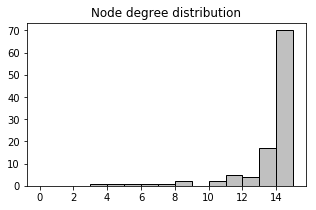

In [4]:
features = [votes_1.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, .5), 15)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)


G= graphs.Graph(adjacency)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

print("Clustering coefficient: " + str(nx.average_clustering(nx.from_numpy_matrix(adjacency))))
print("Diameter: " + str(nx.diameter(nx.from_numpy_matrix(adjacency))))
plt.figure(figsize=(5,3))
plt.hist(adjacency.sum(1), bins=np.linspace(0,15,16), color='silver', lw=1, edgecolor='black')
plt.title("Node degree distribution")
plt.savefig("deg_distribution.png")
plt.show()

Text(0.5,1,'Similarity graph')

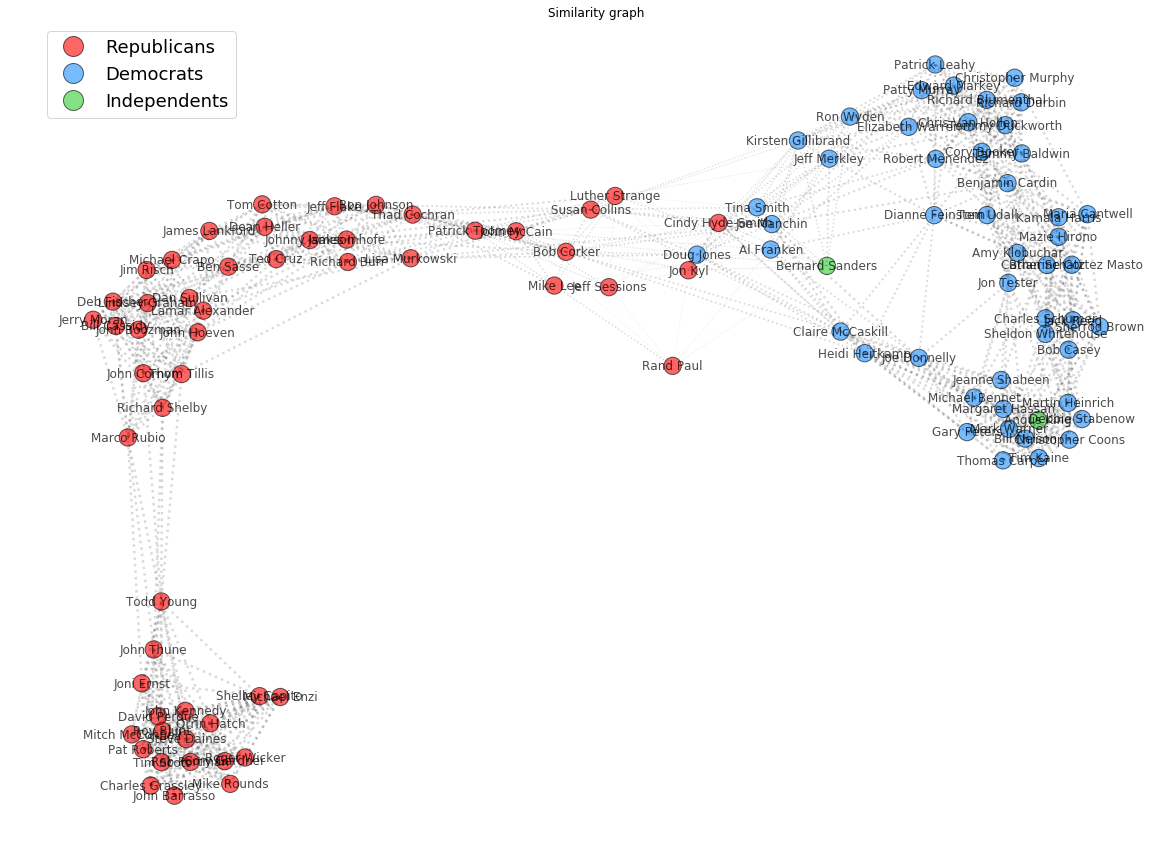

In [5]:

plot_signal(G.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], scale=[0,1])
r = mlines.Line2D([], [], color='red', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Republicans")
d = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black',  alpha=0.6,markersize=20, label="Democrats")
i = mlines.Line2D([], [], color='limegreen', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Independents")

plt.legend(handles=[r,d,i], prop={'size':18})
plt.savefig("similarity_graph.png")
plt.title('Similarity graph')

## Finding influencinal votes
As we would like to model the political orientation of persons which are not in our dataset. We need first to collect voting positions on restricted set of subjects.The latter needs to be chosen carefully in order to maximize the accuracy of our fit.
This why we build a similarity graph where node correspond to bills and features to senators which will help us find influencial votes.We discarded motion votes from this part as they are hard to understand. 
We decided to select 3 influencial votes by using different similarity measure methods that we will detail below.


Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

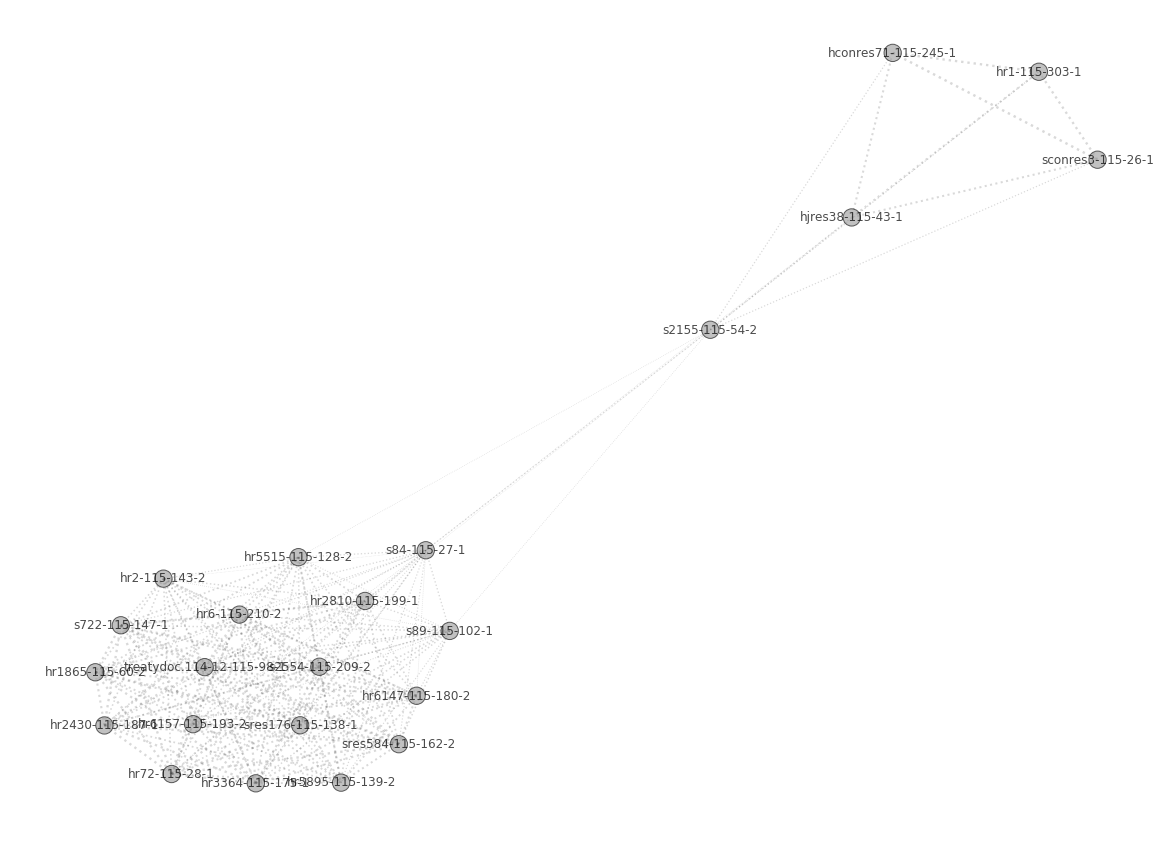

In [6]:
bill_cluster_count = 3

# Build adjacency matrix
features_bills = [votes_1.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg,75),0.7)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

node_degrees = adjacency_bills.sum(1)
G_nx = nx.from_numpy_matrix(adjacency_bills)

# Find largest component
largest_component = max(nx.connected_components(G_nx), key=len)
s = G_nx.subgraph(largest_component)

# build the graph object
G_bills = graphs.Graph(nx.to_numpy_matrix(s))

plot_signal(G_bills.W.todense(),np.array([1]*votes_1.shape[1]), scale=[0,1],labels = votes_1.columns)

In [7]:
# Utils function used to print votes descriptions and to count the occurence number of unique votes
unique_bills = {}
all_bills = {}
best_bills_per_method = []
def print_selected_votes(votes_list,best_bills_idxs):
    """Pretty print a list of selected votes descriptions"""
    selected_votes_unique_ids = votes_list.iloc[:, best_bills_idxs].columns.values
    for v in selected_votes_unique_ids:
        print_info(v)
    bills = [x.split('-')[0] for x in selected_votes_unique_ids]
    return set(bills)

def add_to(dict_,keys):
    """"count the number of occurence of unique keys"""
    for key in keys:
        if key in dict_:
            dict_[key] += 1
        else:
            dict_[key] = 1
        

### Method 1: Find the votes with the highest variance

The following method relies on the 1st feature matrix to find the influencial votes. It return the votes for the highest variance (ie. The votes for which the senators differed the most in term of voting positions

In [10]:
var = np.zeros(votes_1.shape[1])

for i in range(votes_1.shape[1]):
    a = votes_1.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([13, 21,  9])

In [11]:
# Pretty print the selected votes description
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

============== INFORMATION REGARDING hr6147-115-180-2 ============== 

Roll call: 180
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00180

RELATED BILL INFORMATION

Bill title: Making appropriations for the Department of the Interior, environment, and related agencies for the fiscal year ending September 30, 2019, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr6147

Short description: Highlights:  This bill provides FY2019 appropriations for several federal departments and agencies. It includes 4 of the 12 regular FY2019 appropriations bills:    the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2019;   the Financial Services and General Government Appropriations Act, 2019;   the Agriculture, Rural Development, Food and Drug Administration, and Related Agencies Appropriations Act, 2019; and   the Transportation, Housing and Urban Developm...




=

### Method 2: Get smallest number of neighbors
The following method relies on the bills similarity. It return the votes with the smallest number of neighbors.This means that this method selects bills and resolutions with "unique" voting pattern.

In [12]:
# count the number of neighbors per nodes
temp = adjacency_bills.copy()
temp[temp > 0] = 1
# select the nodes with the smallest number of neighbors
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([13,  9, 21])

In [13]:
# Pretty print the selected votes description
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

============== INFORMATION REGARDING hr6147-115-180-2 ============== 

Roll call: 180
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00180

RELATED BILL INFORMATION

Bill title: Making appropriations for the Department of the Interior, environment, and related agencies for the fiscal year ending September 30, 2019, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr6147

Short description: Highlights:  This bill provides FY2019 appropriations for several federal departments and agencies. It includes 4 of the 12 regular FY2019 appropriations bills:    the Department of the Interior, Environment, and Related Agencies Appropriations Act, 2019;   the Financial Services and General Government Appropriations Act, 2019;   the Agriculture, Rural Development, Food and Drug Administration, and Related Agencies Appropriations Act, 2019; and   the Transportation, Housing and Urban Developm...




=

### Method 3: Get closest points of the centers of the cluster of the Bills
The following method relies on the bills similarity graph. It tries to use spectral clustering and K-means to define 3 clusters in our graph.The votes chosen are then the closest ones to the each cluster center

In [14]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()
embedding_dimension = 2
embedding = G_bills.U[:,1:1+embedding_dimension]
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    dist = np.linalg.norm(embedding - centers[j],axis=1)
    vote_repr[j] = np.argmin(dist)
            
vote_repr

array([ 9.,  1., 21.])

In [15]:
add_to(all_bills,vote_repr)

add_to(unique_bills,print_selected_votes(votes_train,vote_repr))
best_bills_per_method.append(vote_repr.astype(int))

============== INFORMATION REGARDING hr2810-115-199-1 ============== 

Roll call: 199
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00199

RELATED BILL INFORMATION

Bill title: To authorize appropriations for fiscal year 2018 for military activities of the Department of Defense and for military construction, to prescribe military personnel strengths for such fiscal year, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr2810

Short description: National Defense Authorization Act for Fiscal Year 2018 This bill authorizes FY2018 appropriations and sets forth policies for Department of Defense (DOD) programs and activities, including military personnel strengths. It does not provide budget authority, which is provided in subsequent appropriations legislation.  The bill authorizes appropriations to DOD for: (1) Procurement, including aircraft, missiles, weapons and tracked combat vehicles

### Method 4: Get the bills with biggest intraparty std
The following method relies on the 1st feature matrix and is similar to method 1.This method identifies the bills which divided the most senators positions inside the same party. This is done by finding the votes which maximize the intraparty standard deviation.

In [16]:
var = np.zeros(votes_1.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes_1.iloc[rep_indexes]
dem_data = votes_1.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([22,  4, 16])

In [17]:
add_to(all_bills,best_bills)

add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

============== INFORMATION REGARDING sconres3-115-13-1 ============== 

Roll call: 13
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00013

RELATED BILL INFORMATION

Bill title: A concurrent resolution setting forth the congressional budget for the United States Government for fiscal year 2017 and setting forth the appropriate budgetary levels for fiscal years 2018 through 2026.

Bill url:  https://www.govtrack.us/congress/bills/115/sconres3

Short description: (This measure has not been amended since it was passed by the Senate on January 12, 2017. The summary of that version is repeated here.) Highlights:  This concurrent resolution establishes the FY2017 congressional budget resolution, which provides a framework for congressional consideration of revenue, spending, and other budget-related legislation. The budget resolution is a nonbinding framework used by Congress and cannot be signed into law or vetoed by the

### Method 5: Get most central nodes using PageRank 
This method relies on the bills similarity and centrality theory.It assign a centrality score to every node using PageRank algorithm and select the nodes with the highest score.

In [18]:
nx_graph = nx.from_numpy_matrix(G_bills.W.todense())
pagerank = nx.pagerank(nx_graph)
pagerank = np.array(list(pagerank.values()))
best_bills = np.argsort(-pagerank)[:bill_cluster_count]
best_bills

array([ 5, 22,  4])

In [19]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

============== INFORMATION REGARDING hr1-115-290-1 ============== 

Roll call: 290
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00290

RELATED BILL INFORMATION

Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2018.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1

Short description: (This measure has not been amended since the House agreed to the Senate amendment without amendment on December 20, 2017. The summary of that version is repeated here.) This bill amends the Internal Revenue Code (IRC) to reduce tax rates and modify policies, credits, and deductions for individuals and businesses. It also establishes an oil and gas leasing program for the Coastal Plain of the Arctic National Wildlife Refuge (ANWR) in Alaska.  (Unless otherwise specified, provisions referred to...




============== INFORMATION REGARDING sconres3-115-13-1

The following results seems to indicate that bills hr2810 and s722 are very influencial as they were selected by 3 out the 5 methods that we defined.

In [22]:
# Print how many times every bill was selected and every vote was selected
for bill,count in  sorted(unique_bills.items(),key=lambda x: -x[1]):
    print('Bill {} was selected by {} methods'.format(bill,count))

Bill hr2810 was selected by 3 methods
Bill s722 was selected by 3 methods
Bill hr6147 was selected by 2 methods
Bill hr1628 was selected by 2 methods
Bill sconres3 was selected by 2 methods
Bill hr6157 was selected by 1 methods
Bill s139 was selected by 1 methods
Bill hr1 was selected by 1 methods


### Find the best initial 3 votes combination

We would like to define a more precise measure for the influence of the selected votes.For this purpose, we measure the mean votes prediction accuracy for every senator when we keep only the 3 selected votes in our training set.We use two different prediction algorithms for this task:
- **Transductive learning**: We run the trusductive learning algorithm on the bills similarity matrix for every senators by keeping only the selected votes labels
- **K-nearest-Neighbors**: Which uses the selected votes to compute the distance between every pair of senators.The final prediction for missing votes corresponding to a senator is based on the voting pattern of its k most similar senators.

In [23]:
def predict_using_initial_votes(votes_selection,votes_df,G_votation,number_of_trials = 1):
    """
    Uses transductive learning to predict missing votes for every senator and return the mean vote prediction accuracy
    on this task
    
    Parameters
    ----------
    votes_selection : nparray
        labeled votes indexes
    votes_df : Dataframe
        votes feature matrix
    G_votation : graph
        Bills similarity graph
    number_of_trials: int (optional)
        Define the number of time each prediction should be run. the final prediction for every vote is a average of
        "number_of_trials" predictions made for it 
    Returns
    -------
    float
        mean vote prediction accuracy
    """
    
    # Votes mask
    w = np.zeros(votes_df.shape[1])
    w[votes_selection] = 1
    accuracies_accumulator = 0
    # Iterate over senators
    for senator in range(votes_df.shape[0]):
        #run prediction
        votes_np = votes_df.iloc[senator,:].values
        available_votes_idx = np.nonzero(votes_np != 0)[0]
        ground_truth = get_thresholded_values(votes_np,0)
        sol, sol_bin = reconstruct_signal(G_votation, w, ground_truth,number_of_trials=number_of_trials)
        #Accumulate the obtained accuracy
        accuracies_accumulator += accuracy(ground_truth[available_votes_idx],sol_bin[available_votes_idx])
    #average accuracies
    accuracies_accumulator /= votes_df.shape[0]
    return accuracies_accumulator


def knn_predict(similar_senators_votes):
    """Predict votes based on k similar voters positions passed in parameters"""
    prediction = np.apply_along_axis(lambda a: np.histogram(a,  bins=[-1,0,1,2])[0], 0, similar_senators_votes)
#     print(prediction)
    prediction = np.argmax(prediction[[0,2],:],axis=0)
    prediction[prediction == 0] = -1
    return prediction
def predict_using_initial_votes_2(votes_selection,votes_df,number_of_neighbors = 3):
    """
    Uses KNN to predict missing votes for every senator and return the mean vote prediction accuracy
    on this task
    
    Parameters
    ----------
    votes_selection : nparray
        labeled votes indexes
    votes_df : Dataframe
        votes feature matrix
    number_of_neighbors : int (optional)
        The number of similar senators to take into account for every prediction
    Returns
    -------
    float
        mean vote prediction accuracy
    """
    accuracies_accumulator = 0
    tmp = votes_df.iloc[:,votes_selection].values
    # compute pairwise distance between all the senators using the selected votes
    model = NearestNeighbors(n_neighbors=number_of_neighbors+1, algorithm='ball_tree').fit(tmp)
    distances, indices = model.kneighbors(tmp)
    distances = distances[:,1:]
    indices = indices[:,1:]
    selector = np.arange(votes_df.shape[1])
    selector = np.nonzero(~np.isin(selector,votes_selection))[0]
    total = 0
    for senator in range(votes_df.shape[0]):
        #select the most similar senators votes
        similar_senators = indices[senator]
        similar_senators_votes = votes_df.iloc[similar_senators].values[:,selector]
        
        #Select the ground truth for the predicted votes (used later for accuracy measures)
        ground_truth = votes_df.iloc[senator,selector].values
        available_votes_idx = np.nonzero(ground_truth != 0)[0]
        ground_truth = ground_truth[available_votes_idx]
        
        # Make predictions only if we have ground truth for the selected votes
        if  len(ground_truth):
            sol = knn_predict(similar_senators_votes)
            acc = accuracy(ground_truth,sol[available_votes_idx])
            accuracies_accumulator  += acc
            total+=1
    accuracies_accumulator /= total
    return accuracies_accumulator


def find_best_votes(selected_search_space,votes_df,G_bills):
    """
    print the best initial 3 votes combination using transductive learning and KNN
    
    Parameters
    ----------
    selected_search_space : list of lists
        selected votes combinations
    votes_df : Dataframe
        votes feature matrix
    G_bills : Graph
        Bills similary graph 
    Returns
    -------
    None
        
    """
    
    all_votes_combinations_accuracies = []
    all_votes_combinations_accuracies_2 = []
    
    for idx,votes_combination in enumerate(selected_search_space):
        print(str(idx+1)+'/'+str(len(selected_search_space)),end='\r')
        # Make predictions
        all_votes_combinations_accuracies.append(predict_using_initial_votes(votes_combination,votes_df,G_bills))
        all_votes_combinations_accuracies_2.append(predict_using_initial_votes_2(votes_combination,votes_df))

    # Find best votes combination
    best_method_1,best_method_2 = np.argmax(np.array(all_votes_combinations_accuracies)),np.argmax(np.array(all_votes_combinations_accuracies_2))
    combination_1,combination_2 = selected_search_space[best_method_1],selected_search_space[best_method_2]
    
    # Pretty print the best combinations
    data = (best_method_1,best_method_2),(all_votes_combinations_accuracies[best_method_1],all_votes_combinations_accuracies_2[best_method_2])
    log_best_votes(data,selected_search_space,votes_df)



all_votes_combinations = [[int(y) for y in x] for x in combinations(all_bills.keys(),3)]
G_bills.compute_differential_operator()

def log_best_votes(data,search_space,votes_df):
    """Pretty print 'find_best_votes' function results"""
    (m1,m2),(acc1,acc2) = data
    print('---------Transductive Learning benchmark------------')
    print('Best Value Index: {}'.format(m1))
    print('Accuracy: {}'.format(acc1))
    print('Votes idxs: {}'.format(search_space[m1]))
    print('Votes selected {}'.format([x for x in votes_df.iloc[:,search_space[m1]].columns]))
    
    print('---------KNN benchmark------------')
    print('Best Value Index: {}'.format(m2))
    print('Accuracy: {}'.format(acc2))
    print('Votes idxs: {}'.format(search_space[m2]))
    print('Votes selected {}'.format([x for x in votes_df.iloc[:,search_space[m2]].columns]))

In [26]:
# Find the best initial votes combination regardless of the selection method
find_best_votes(all_votes_combinations,votes_1,G_bills)

---------Transductive Learning benchmark------------
Best Value Index: 6
Accuracy: 0.9498592849524529
Votes idxs: [13, 9, 1]
Votes selected ['sconres3-115-26-1', 'hconres71-115-245-1', 's722-115-147-1']
---------KNN benchmark------------
Best Value Index: 41
Accuracy: 0.9573140367258017
Votes idxs: [9, 22, 16]
Votes selected ['hconres71-115-245-1', 'hr2810-115-199-1', 's89-115-102-1']


In [28]:
# Find the best initial votes combination by only considering combinations returned by individual selection methods

find_best_votes(best_bills_per_method,votes_1,G_bills)

---------Transductive Learning benchmark------------
Best Value Index: 2
Accuracy: 0.9465636847624427
Votes idxs: [ 9  1 21]
Votes selected ['hconres71-115-245-1', 's722-115-147-1', 'hr1-115-303-1']
---------KNN benchmark------------
Best Value Index: 2
Accuracy: 0.9407615443838355
Votes idxs: [ 9  1 21]
Votes selected ['hconres71-115-245-1', 's722-115-147-1', 'hr1-115-303-1']


As we can see from the results above. The bills clustering technique (Method 3) is the best at selecting the 3 initial votes. Hence we will use its results for the next steps

In [29]:
vote_repr = best_bills_per_method[2]

## Vote selection

['hr2810-115-199-1' 'hr6157-115-193-2' 's722-115-147-1']


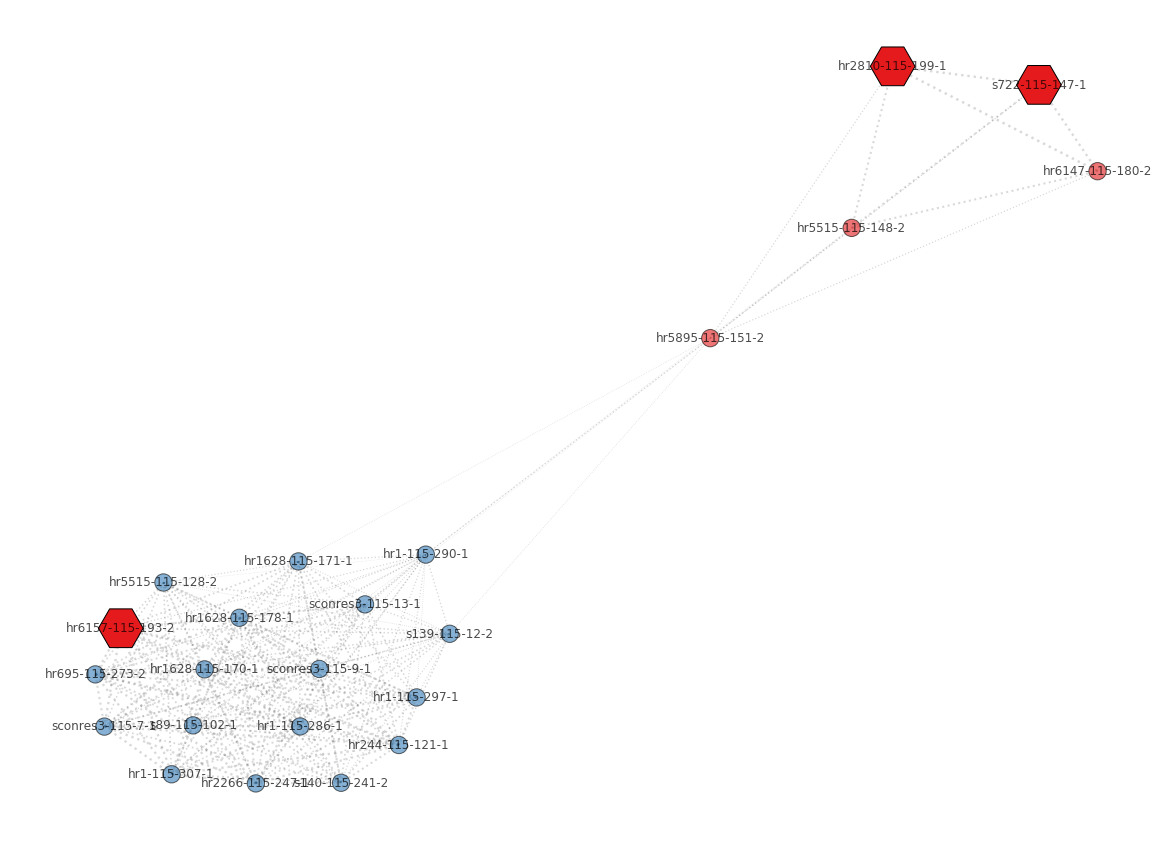

In [30]:
vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))

## Embedding you in the graph

In this section, we use the votes and similarity graphs built above to model your political orientation.The widget below shows the senators that are likely to have similar political opinion, it also measure your position in the political spectrum (Liberal/conservative) using spetral clustering on a modified version of the senators similarity graph

In [67]:
your_votes = [1,1,-1]
other_senators_vote = votes_train.values[:,vote_selection]

In [38]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [39]:
def compute_similarity(senator_votes,your_votes):
    """Compute the cosine similarity between your_votes and other senators votes"""
    return cosine_similarity(senator_votes, your_votes)

against='Against'
pro='Pro'
neutral='Neutral'

G_extended = None

@interact(vote1=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote2=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote3=[(against,-1.0),(neutral,0.0),(pro,1.0)])
def choose(vote1=1.0,vote2=1.0,vote3=1.0):
    """Displays The pictures of the most similar senators to you, as well as a similarity graph and a plot which show your
    position on the political specturm based on vote1,vote2 and vote3"""
    your_votes=[vote1,vote2,vote3]
    other_senators_vote = votes_train.values[:,vote_selection]
    similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote,your_votes)
    similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)

    top_similar = similarity_vector.argsort()[-3:][::-1]
    similar_senators = senators.iloc[top_similar]
    show_portraits(similar_senators)
    new_columns = np.append(similarity_vector, 0)

    n = len(adjacency)
    new_adjacency = np.zeros((n+1, n+1))
    new_adjacency[:n,:n] = adjacency
    new_adjacency[n,:] = new_columns
    new_adjacency[:,n] = new_columns

    global G_extended
    G_extended = graphs.Graph(new_adjacency)
    G_extended.set_coordinates('spring', seed=2018)
    G_extended.compute_fourier_basis()
    G_extended.compute_laplacian()
    G_extended.compute_differential_operator()
    colors = {0:'red',1:'blue',2:'green', 3:'orange'}

    
    new_labels = np.append(senators['name'].values, ['you'])
    
    plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])
    show_2D_embedding(G_extended.U[:,1:3], senators_party)
    show_political_spectrum(G_extended.U[:,1:3], n, colors, senators_party)

interactive(children=(Dropdown(description='vote1', index=2, options=(('Against', -1.0), ('Neutral', 0.0), ('P…

## Vote predictions using Transductive learning
We use below the new similarity graph which contains your voting positions in order to predict your voting outcome on new subjects

In [40]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    w = np.append(np.ones(len(positions)), 0)    

    return reconstruct_signal(G, w, get_thresholded_values(bill_votes,0),number_of_trials=number_of_trials)

sol, sol_binarized = predict_your_votes(G_extended, votes_1.iloc[:,2])
print("On vote x you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")

On vote x you would have voted 1.0 (0.9963529204480408)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters.In this part we would like to show that we can accurately predict the outcome of a votes (passed/rejected) by only looking at the swing senators voting positions. For this purpose,we use a different similarity graph built using the second feature matrix defined in the feature engineering notebook. The latter contains all the votes on bills,resolution and motions passage. We divide the collected votes into a training and test set using a 80:20 split.

In [43]:
votes_2 = pd.read_pickle("data/processed/processed_votes_2.pickle")
print("\n\n\nThe 2nd vote dataframe is a " + str(votes_2.shape) + " table with senators as rows and vote positions as columns.")
# Separate the second votes matrix into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.8, votes_2)
display(votes_2.head(3))

features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, .5), 15)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)


G= graphs.Graph(adjacency)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()




The 2nd vote dataframe is a (105, 109) table with senators as rows and vote positions as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hconres71-115-245-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,...,sconres3-115-26-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1,sres176-115-138-1,sres584-115-162-2,treatydoc.114-12-115-98-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0


We identify swing senators by defining a score which measure how closely is a senator related to senators from another political party.This done using the following formula
$$Score_i = \frac{\Sigma_{j \in A_i}W_{ij}}{\Sigma_{j=1}^n W_{ij}}$$
where W is the similarity graph adjacency matrix and $A_i$ is the set of senators which are not in the same party of senator i

In [ ]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    """
    Compute the swing score for every senator
    
    Parameters
    ----------
    adjacency : ndarray
        similarity graph adjacency matrix
    labels : array
        Senators political affiliation (Republican,Democrat,Independant)
        
    Returns
    -------
    numpy.array
    The swing score for every senator
        
    """
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

We then predict the outcome of the votes in our test set using the selected swing senators votes using transductive learning

In [46]:
print(senators['name'].iloc[swing_senators])

a = predict_and_compare(G, votes_test, swing_senators)

member_id
C001035       Susan Collins
H001041         Dean Heller
H001079    Cindy Hyde-Smith
J000300          Doug Jones
K000352             Jon Kyl
M001153      Lisa Murkowski
S000033     Bernard Sanders
S001141       Jeff Sessions
S001202      Luther Strange
S001203          Tina Smith
Name: name, dtype: object
True: {-1: 48, 1: 57} Pred: {-1: 1, 1: 104}
True: {-1: 52, 1: 53} Pred: {-1: 52, 1: 53}
True: {-1: 17, 1: 88} Pred: {-1: 1, 1: 104}
True: {-1: 11, 1: 94} Pred: {-1: 1, 1: 104}
True: {-1: 2, 1: 103} Pred: {1: 105}
True: {-1: 47, 1: 58} Pred: {-1: 1, 1: 104}
True: {-1: 57, 1: 48} Pred: {-1: 52, 1: 53}
True: {-1: 1, 1: 104} Pred: {1: 105}
True: {-1: 47, 1: 58} Pred: {-1: 43, 1: 62}
True: {1: 105} Pred: {1: 105}
True: {-1: 7, 1: 98} Pred: {-1: 1, 1: 104}
True: {-1: 31, 1: 74} Pred: {-1: 49, 1: 56}
True: {-1: 50, 1: 55} Pred: {-1: 47, 1: 58}
True: {-1: 67, 1: 38} Pred: {-1: 1, 1: 104}
True: {-1: 51, 1: 54} Pred: {-1: 52, 1: 53}
True: {-1: 51, 1: 54} Pred: {-1: 52, 1: 53}
True: {-1

We were able to predict accurately the outcome of the test votes 90% of the time.In order to show the importance of swing senator we will run the same prediction task using random senators voting positions instead of swing senators voting positions 

In [48]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
a = predict_and_compare(G, votes_test, random_senators)

                      name party
member_id                       
R000605        Mike Rounds     R
F000457         Al Franken     D
M001183        Joe Manchin     D
P000603          Rand Paul     R
C001098           Ted Cruz     R
C001070          Bob Casey     D
F000444         Jeff Flake     R
C000141    Benjamin Cardin     D
H001061        John Hoeven     R
B001267     Michael Bennet     D
True: {-1: 48, 1: 57} Pred: {-1: 52, 1: 53}
True: {-1: 52, 1: 53} Pred: {-1: 53, 1: 52}
True: {-1: 17, 1: 88} Pred: {1: 105}
True: {-1: 11, 1: 94} Pred: {-1: 5, 1: 100}
True: {-1: 2, 1: 103} Pred: {-1: 2, 1: 103}
True: {-1: 47, 1: 58} Pred: {-1: 47, 1: 58}
True: {-1: 57, 1: 48} Pred: {-1: 58, 1: 47}
True: {-1: 1, 1: 104} Pred: {1: 105}
True: {-1: 47, 1: 58} Pred: {-1: 53, 1: 52}
True: {1: 105} Pred: {1: 105}
True: {-1: 7, 1: 98} Pred: {-1: 4, 1: 101}
True: {-1: 31, 1: 74} Pred: {-1: 24, 1: 81}
True: {-1: 50, 1: 55} Pred: {-1: 53, 1: 52}
True: {-1: 67, 1: 38} Pred: {-1: 60, 1: 45}
True: {-1: 51, 1:

As we can see from the resuts above the accuracy obtained by selecting random senators votes as initial votes for our transductive learning task yield to worse results. This experiment proves the importance of swing senators

In [ ]:
labels_bin = get_thresholded_values(votes_test.values[:,8], threshold=0)

mask = np.zeros(votes_test.shape[0])
mask[swing_senators] = 1

sol, sol_bin =  reconstruct_signal(G,mask,labels_bin)
plot_prediction(G, sol_bin, labels_bin, mask)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))


Text(0.5,1,'Similarity graph with the percentage of votes with party as label')

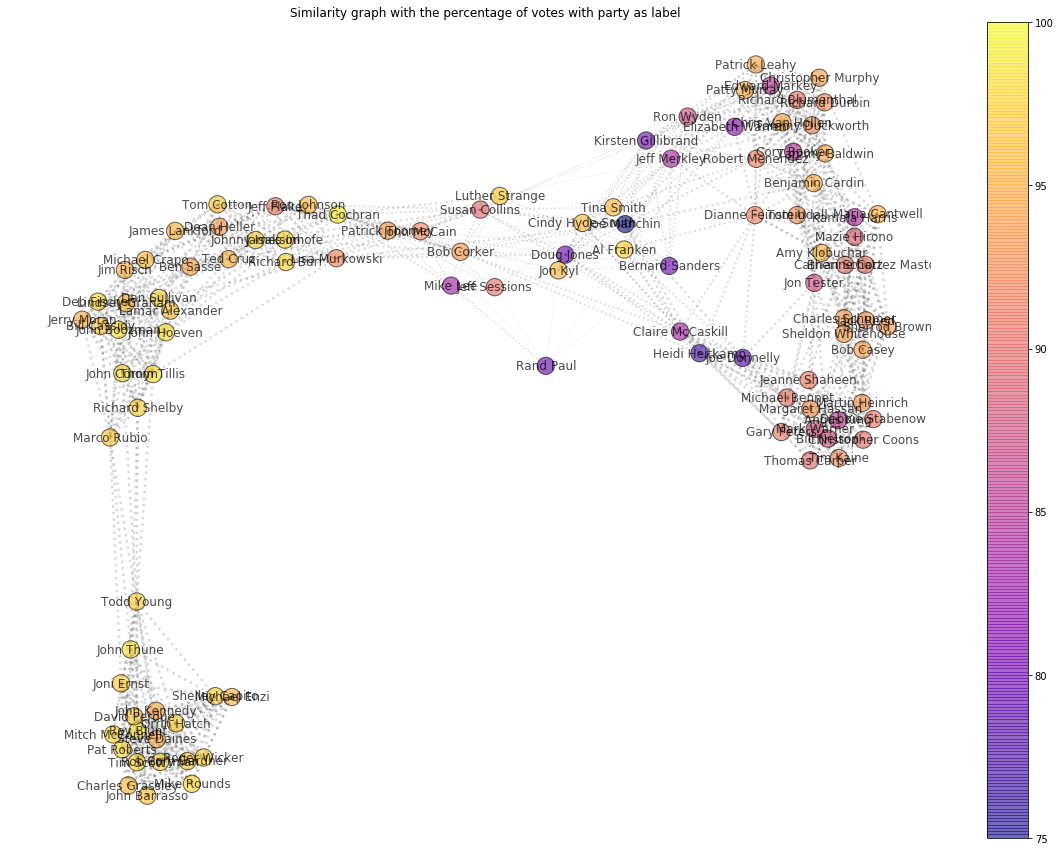

In [13]:
a = plot_signal(G.W.todense(), senators['votes_with_party_pct'].map(float), labels=senators['name'], scale=[75,100], colormap='plasma')
plt.colorbar(a,aspect=20)

plt.title('Similarity graph with the percentage of votes with party as label')

In [ ]:
# Binarize labels
labels_bin = get_thresholded_values(votes_test.values[:,35], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

In [ ]:
sol, sol_bin =  reconstruct_signal(G,w,labels_bin)
plot_prediction(G, sol_bin, labels_bin, w)
plt.savefig("prediction_result.png")
print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))